## Python tutotial

This notebook gives a basic demonstration of how to access and use the shapefiles included in the Australian Community Reference Climate Data Collection. It relies heavily on the functionality included in a Python package called [regionmask](https://regionmask.readthedocs.io/) - see the package documentation for more details. 

In [1]:
import calendar

import xarray as xr
import geopandas as gp
import regionmask
import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from matplotlib import colors as mplc
import numpy as np

### Step 1: Read data

We will start by reading in monthly mean temperature data from a coarse resolution CMIP6 model:

In [2]:
filedir = '/g/data/oi10/replicas/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/historical/r1i1p1f1/Amon/tas/gr/v20180803/'
ds = xr.open_dataset(filedir + 'tas_Amon_IPSL-CM6A-LR_historical_r1i1p1f1_gr_185001-201412.nc')

In [3]:
print(ds)

<xarray.Dataset> Size: 163MB
Dimensions:      (lat: 143, lon: 144, time: 1980, axis_nbounds: 2)
Coordinates:
  * lat          (lat) float32 572B -90.0 -88.73 -87.46 ... 87.46 88.73 90.0
  * lon          (lon) float32 576B 0.0 2.5 5.0 7.5 ... 350.0 352.5 355.0 357.5
    height       float64 8B ...
  * time         (time) datetime64[ns] 16kB 1850-01-16T12:00:00 ... 2014-12-1...
Dimensions without coordinates: axis_nbounds
Data variables:
    time_bounds  (time, axis_nbounds) datetime64[ns] 32kB ...
    tas          (time, lat, lon) float32 163MB ...
Attributes: (12/51)
    Conventions:            CF-1.7 CMIP-6.2
    creation_date:          2018-07-11T07:36:34Z
    tracking_id:            hdl:21.14100/285a3a27-0287-4e3b-8232-69ddc89cebef
    description:            CMIP6 historical
    title:                  IPSL-CM6A-LR model output prepared for CMIP6 / CM...
    activity_id:            CMIP
    ...                     ...
    name:                   /ccc/work/cont003/gencmip6/p86caub/I

### Step 2: Read shapefiles

Let's say we are interested in selecting model grid points that fall within specific Australian states and territores and also in calculating spatially averaged temperatures for each state/territory.

To complete this task we can use the [`aus_states_territories`](https://github.com/aus-ref-clim-data-nci/shapefiles/blob/master/aus_states_territories.ipynb) shapefiles in the collection.

We can read those shapefiles using the geopandas library:

In [4]:
states_gp = gp.read_file('/g/data/ia39/aus-ref-clim-data-nci/shapefiles/data/aus_states_territories/aus_states_territories.shp')

In [5]:
states_gp['abbrev'] = ['NSW', 'VIC', 'QLD', 'SA', 'WA', 'TAS', 'NT', 'ACT', 'OT']

In [6]:
states_gp

,STE_NAME21,AREASQKM21,LOCI_URI21,geometry,abbrev
0,New South Wales,8.007977e+05,http://linked.data.gov.au/dataset/asgsed3/STE/1,"MULTIPOLYGON (((159.06230 -31.50886, 159.06218...",NSW
1,Victoria,2.274962e+05,http://linked.data.gov.au/dataset/asgsed3/STE/2,"MULTIPOLYGON (((146.29286 -39.15778, 146.29341...",VIC
2,Queensland,1.730171e+06,http://linked.data.gov.au/dataset/asgsed3/STE/3,"MULTIPOLYGON (((142.53140 -10.68301, 142.53072...",QLD
3,South Australia,9.842314e+05,http://linked.data.gov.au/dataset/asgsed3/STE/4,"MULTIPOLYGON (((140.66025 -38.06256, 140.66006...",SA
4,Western Australia,2.526632e+06,http://linked.data.gov.au/dataset/asgsed3/STE/5,"MULTIPOLYGON (((117.86953 -35.19108, 117.86961...",WA
5,Tasmania,6.801754e+04,http://linked.data.gov.au/dataset/asgsed3/STE/6,"MULTIPOLYGON (((144.60439 -41.01001, 144.60443...",TAS
6,Northern Territory,1.348134e+06,http://linked.data.gov.au/dataset/asgsed3/STE/7,"MULTIPOLYGON (((133.02818 -10.90839, 133.02982...",NT
7,Australian Capital Territory,2.358133e+03,http://linked.data.gov.au/dataset/asgsed3/STE/8,"POLYGON ((149.06239 -35.15910, 149.09134 -35.1...",ACT
8,Other Territories,2.557420e+02,http://linked.data.gov.au/dataset/asgsed3/STE/9,"MULTIPOLYGON (((167.94747 -29.12757, 167.94748...",OT


We're working with a coarse resolution model with grid cells much larger than the ACT and other territories, so we'll leave those out:

In [7]:
states_gp = states_gp[:-2]

We now need to turn our geopandas GeoDataFrame into a regionmask Regions object:

In [8]:
type(states_gp)

geopandas.geodataframe.GeoDataFrame

In [9]:
states_regions = regionmask.from_geopandas(
    states_gp,
    names="STE_NAME21",
    abbrevs="abbrev",
    name="states"
)

In [10]:
type(states_regions)

regionmask.core.regions.Regions

In [11]:
print(states_regions)

<regionmask.Regions 'states'>
overlap:  None

Regions:
0 NSW    New South Wales
1 VIC           Victoria
2 QLD         Queensland
3  SA    South Australia
4  WA  Western Australia
5 TAS           Tasmania
6  NT Northern Territory

[7 regions]


### Step 3: Create a mask

Our `states_regions` object comes with a method called `mask_3D` that can create a mask for a given lat/lon grid. If our xarray Dataset (`ds`) has a latitude dimension called `lat` and a longitude dimension called `lon` we can simply pass it to that method. It will create a "mask" array that is `True` for all grid cells whose centre point falls within a particular state/territory and `False` elsewhere:

In [12]:
mask_centre = states_regions.mask_3D(ds)

In [13]:
print(mask_centre)

<xarray.DataArray 'mask' (region: 7, lat: 143, lon: 144)> Size: 144kB
array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
...
        ...,
        [False,

If we don't want to select grid points based on whether their centre point falls within a shape, we can instead use the `mask_3D_frac_approx` method to calculate the fraction of each grid cell that overlaps with each shape (this can be more memory and time intensive than the default centre point method):

In [14]:
frac = states_regions.mask_3D_frac_approx(ds)

In [15]:
print(frac)

<xarray.DataArray 'mask' (region: 7, lat: 143, lon: 144)> Size: 1MB
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
...
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],

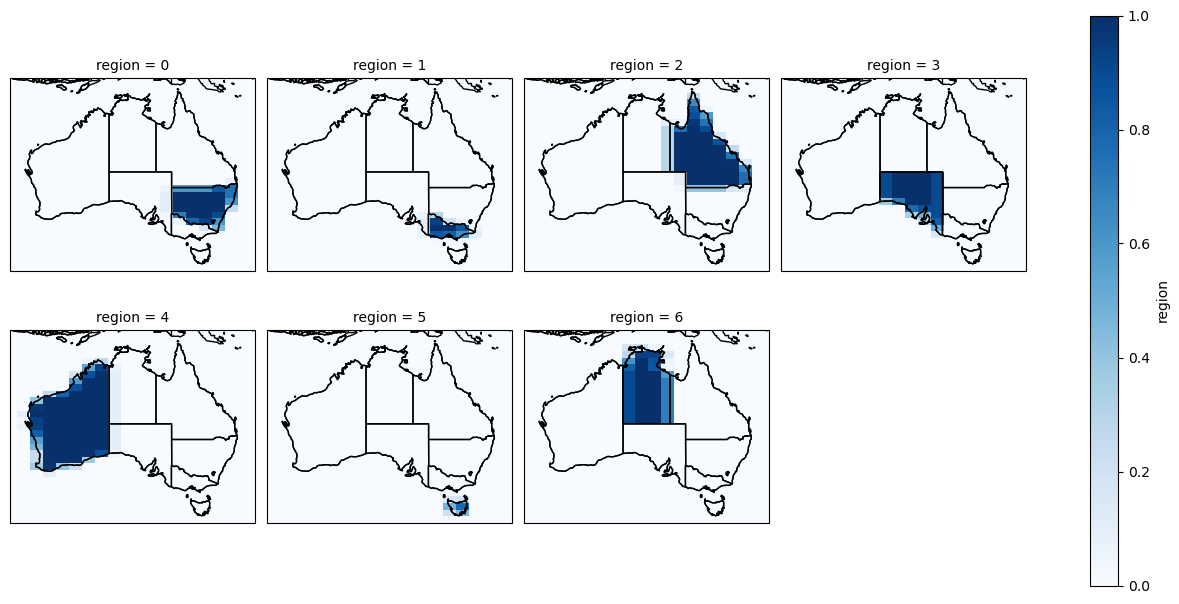

In [16]:
fg = frac.plot(
    subplot_kws=dict(projection=ccrs.PlateCarree()),
    col="region",
    col_wrap=4,
    transform=ccrs.PlateCarree(),
    cmap='Blues',
)
for ax in fg.axs.flatten():
    ax.coastlines()
    ax.set_extent([110, 157, -8, -45], crs=ccrs.PlateCarree())
    ax.add_feature(cartopy.feature.STATES)
plt.show()

To create a mask (i.e. a `True`/`False` array) from the fraction values we need to decide on a minimum overlap threshold. Let's say we want ot include all grid points with more than 10% overlap with the shape:

In [17]:
overlap_threshold = 0.1
mask_10pct = frac >= overlap_threshold

In [18]:
print(mask_10pct)

<xarray.DataArray 'mask' (region: 7, lat: 143, lon: 144)> Size: 144kB
array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
...
        ...,
        [False,

We can now plot our `mask_centre` and `mask_10pct` objects to see what difference it makes to use the centre point versus >10% overlap method on the IPSL-CM6A-LR model grid: 

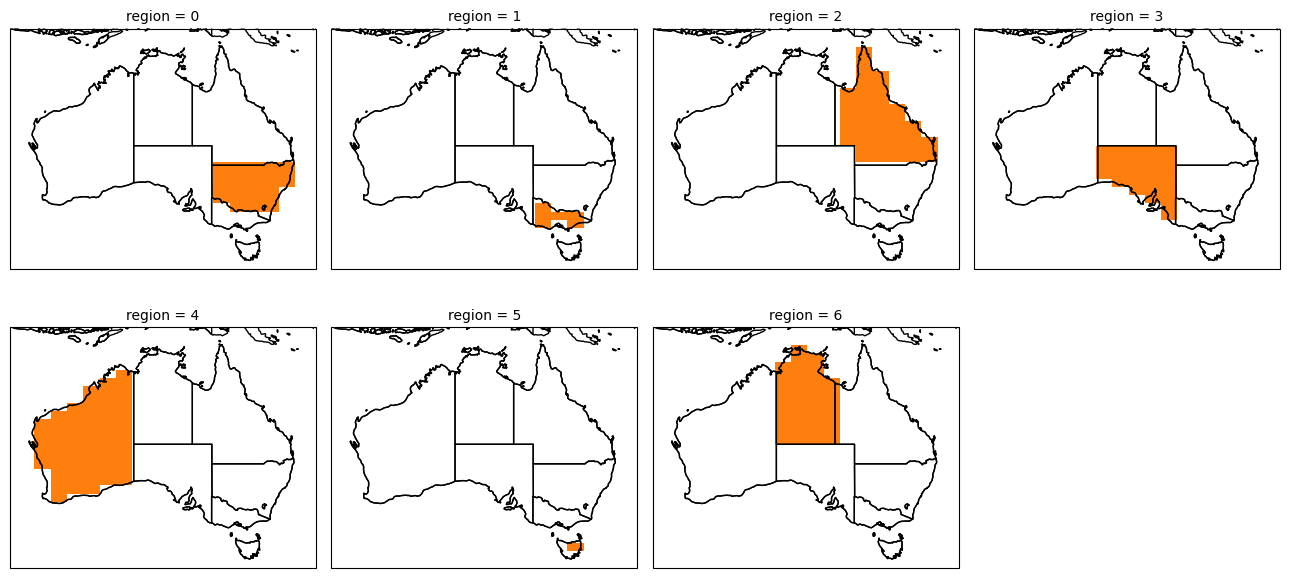

In [19]:
fg = mask_centre.plot(
    subplot_kws=dict(projection=ccrs.PlateCarree()),
    col="region",
    col_wrap=4,
    transform=ccrs.PlateCarree(),
    add_colorbar=False,
    cmap=mplc.ListedColormap(["none", "tab:orange"]),
)
for ax in fg.axs.flatten():
    ax.coastlines()
    ax.set_extent([110, 157, -8, -45], crs=ccrs.PlateCarree())
    ax.add_feature(cartopy.feature.STATES)
fg.fig.subplots_adjust(hspace=0.1, wspace=0.05)
plt.show()

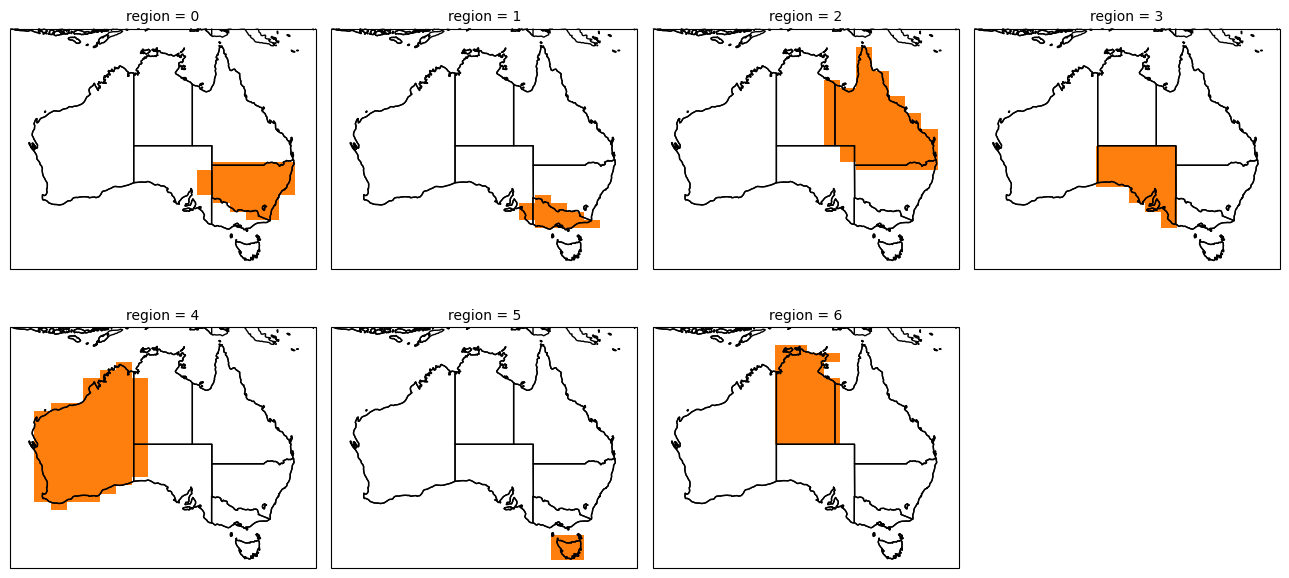

In [20]:
fg = mask_10pct.plot(
    subplot_kws=dict(projection=ccrs.PlateCarree()),
    col="region",
    col_wrap=4,
    transform=ccrs.PlateCarree(),
    add_colorbar=False,
    cmap=mplc.ListedColormap(["none", "tab:orange"]),
)
for ax in fg.axs.flatten():
    ax.coastlines()
    ax.set_extent([110, 157, -8, -45], crs=ccrs.PlateCarree())
    ax.add_feature(cartopy.feature.STATES)
fg.fig.subplots_adjust(hspace=0.1, wspace=0.05)
plt.show()

### Final step: Apply a mask

We've now reached the point where we can apply a mask to our data. Let's use our centre point mask (`mask_centre`) to mask out all grid points except those in Queensland (noting that the same steps would apply for the >10% overlap mask).

There are three different ways we can select Queensland from `mask_centre` (which as we've seen contains a separate mask for each state and territory):

In [21]:
#qld_mask = mask_centre.sel(region=2)
#qld_mask = mask_centre.isel(region=(mask_centre.abbrevs == "QLD"))
qld_mask = mask_centre.isel(region=(mask_centre.names == "Queensland"))

We can then apply that mask to our temperature data:

In [22]:
ds_qld = ds.where(qld_mask)

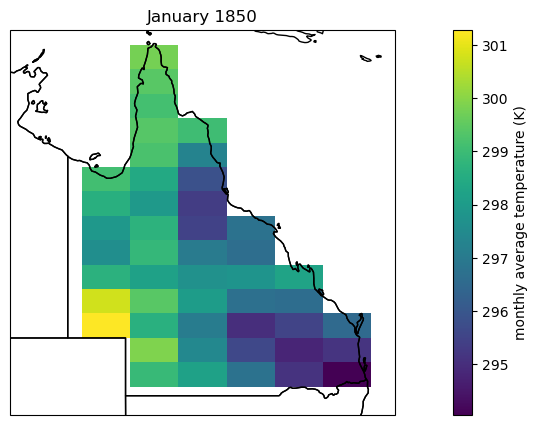

In [23]:
fig = plt.figure(figsize=[15, 5])
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
ds_qld['tas'].isel(time=0).plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cbar_kwargs={'label': f'monthly average temperature (K)'},
)
ax.set_extent([135, 155, -10, -30], crs=ccrs.PlateCarree())
ax.set_title('January 1850')
ax.coastlines()
ax.add_feature(cartopy.feature.STATES)
plt.show()

### Final step: Calculate a (weighted) regional mean

Rather than applying a mask as above, an alternative final step for our analysis might be to spatially aggregate our data for each state and territory (e.g. via a weighted mean). The area weights for each grid point depend on latitude: 

In [24]:
weights = np.cos(np.deg2rad(ds['lat']))

If we only want to include the grid cells whose centre point falls within each state/territory in our average we can multiply `weights` by our `mask_centre` values. Since `mask_centre` is a boolean array of `True`/`False` values and Python interprets `True` = 1 and `False` = 0, all weights outside the state/territory of interest would effectively be set to zero. 

A more accurate method would be to multiply `weights` by the fractional overlap (`frac`) that we calculated earlier. That will ensure that an appropriate fractional value of the grid cells that are on the edge of the state/territory get included in the weighted average:

In [25]:
spatial_means = ds['tas'].weighted(frac * weights).mean(dim=("lat", "lon"))

In [26]:
print(spatial_means)

<xarray.DataArray 'tas' (time: 1980, region: 7)> Size: 111kB
array([[293.37424401, 288.68098103, 297.72784719, ..., 297.85014007,
        285.30517077, 298.87328225],
       [296.30908056, 294.6918192 , 297.88354417, ..., 298.8720362 ,
        288.67071241, 298.62891978],
       [292.7516661 , 290.72738047, 296.55807025, ..., 299.45531755,
        287.85246516, 298.26027227],
       ...,
       [291.10237046, 285.58988928, 297.58964438, ..., 295.36135711,
        282.35244706, 299.0060441 ],
       [292.55920747, 288.72538479, 298.08639719, ..., 297.59309717,
        283.94279274, 299.33052656],
       [295.59548465, 291.62476008, 298.30341363, ..., 300.62327156,
        286.30530875, 299.79627315]])
Coordinates:
    height   float64 8B 2.0
  * time     (time) datetime64[ns] 16kB 1850-01-16T12:00:00 ... 2014-12-16T12...
  * region   (region) int64 56B 0 1 2 3 4 5 6
    abbrevs  (region) <U3 84B 'NSW' 'VIC' 'QLD' 'SA' 'WA' 'TAS' 'NT'
    names    (region) <U18 504B 'New South Wales' ...

We now have a single monthly mean value for each state and territory (a total of 1,980 values from January 1850 to December 2014).

Let's calculate and plot the monthly climatology for each state/territory:

In [27]:
monthly_clim = spatial_means.groupby('time.month').mean()

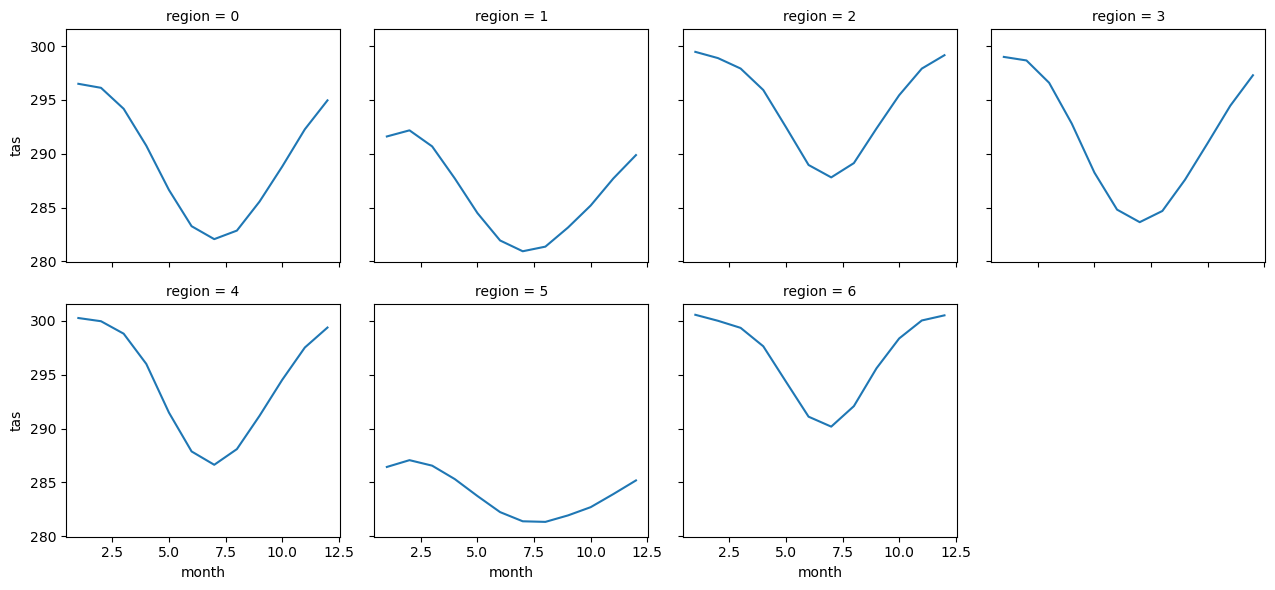

In [28]:
monthly_clim.plot(col="region", col_wrap=4)
plt.show()